# AD HOC dataset all tests here

### Required imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer

from qiskit.ml.datasets import iris

from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name


seed = 10599
aqua_globals.random_seed = seed


### Load adhoc dataset

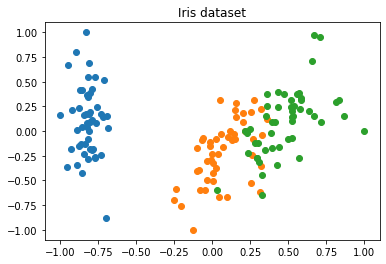

In [48]:
adhoc_dimension = 4

sample_train, training_input_, test_input_, class_labels = iris(
    training_size=50,
    test_size=50, 
    n=adhoc_dimension, 
    plot_data=True
)
class_labels = class_labels[:2]

training_input = {}
training_input['A'] = training_input_['A'][:25]
training_input['B'] = training_input_['B'][:25]

test_input = {}
test_input['A'] = training_input_['A'][25:40]
test_input['B'] = training_input_['B'][25:40]

extra_test_data = {}
extra_test_data['A'] = training_input_['A'][40:]
extra_test_data['B'] = training_input_['B'][40:]

datapoints, _ = split_dataset_to_data_and_labels(extra_test_data)
(unseen_features, unseen_labels) = datapoints
(train_features, train_labels), _ = split_dataset_to_data_and_labels(training_input)
(test_features, test_labels), _ = split_dataset_to_data_and_labels(test_input)

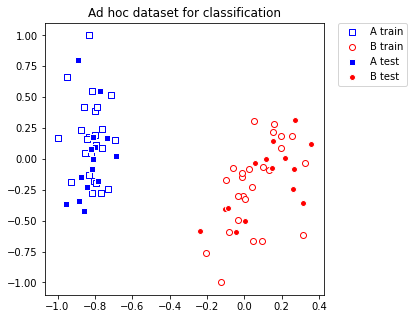

In [46]:
plt.figure(figsize=(5, 5))

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

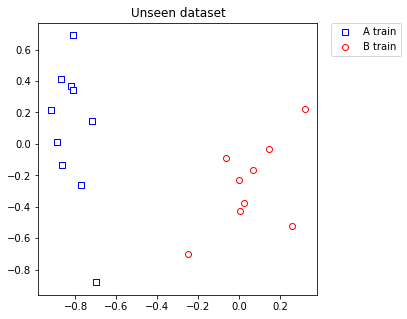

In [50]:
plt.figure(figsize=(5, 5))

plt.scatter(
    unseen_features[np.where(unseen_labels[:] == 0), 0],
    unseen_features[np.where(unseen_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    unseen_features[np.where(unseen_labels[:] == 1), 0],
    unseen_features[np.where(unseen_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Unseen dataset")

plt.show()

#### Set backend

In [51]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

In [39]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap

def create_feature_map(type, feature_dimension, entanglement=None):
	feature_map = None
	if type == 'pauli':
		feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement=entanglement, insert_barriers=True)
	if type == 'zz':
		feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, insert_barriers=True)
	if type == 'z':
		feature_map = ZFeatureMap(feature_dimension=feature_dimension, reps=2, insert_barriers=True)
	feature_map.decompose().draw(output='mpl', fold=-1)
	return feature_map
	

In [40]:
from qiskit.aqua.algorithms import SklearnSVM, VQC, QSVM
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal

def run_model(model, adhoc_feature_map, training_input, test_input, datapoints):
	_model = None
	if model == 'qsvm':
		_model = QSVM(adhoc_feature_map, training_input, test_input, datapoints[0])
		result = _model.run(quantum_instance)
	if model == 'vqc':
		_model = VQC(
			SPSA(maxiter=40, c0=4.0, skip_calibration=True), 
			adhoc_feature_map, 
			TwoLocal(adhoc_dimension, ['ry', 'rz'], 'cz', reps=3), 
			training_input, 
			test_input, 
			datapoints[0])
		result = _model.run(quantum_instance)		
	if model == 'svm':
		_model = SklearnSVM(training_input, test_input, datapoints[0])
		result = _model.run()

	print(f'Testing success ratio: {result["testing_accuracy"]}')
	print()
	print('Prediction from datapoints set:')
	print(f'  ground truth: {map_label_to_class_name(datapoints[1], _model.label_to_class)}')
	print(f'  prediction:   {result["predicted_classes"]}')
	predicted_labels = result["predicted_labels"]
	print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')
	
	return _model, result

In [41]:
def display_kernel_matrices(result):
    adhoc_matrix_train = result['kernel_matrix_training']
    adhoc_matrix_test = result['kernel_matrix_testing']

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(
        np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
    )
    axs[0].set_title("Ad hoc training kernel matrix")
    axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
    axs[1].set_title("Ad hoc testing kernel matrix")
    plt.show()

In [42]:
feature_maps = ['pauli', 'zz', 'z']
entanglements = ['linear', 'circular', 'full']
models = ['qsvm', 'vqc']

In [43]:
def do_all(model, feature, feature_dimention, training_input, test_input, datapoints, ent=None):
	feature_map = create_feature_map(feature, feature_dimention, ent)
	_, result = run_model(model, feature_map, training_input, test_input, datapoints)
	if model != 'vqc':
		display_kernel_matrices(result)

### SVM

Testing success ratio: 1.0

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


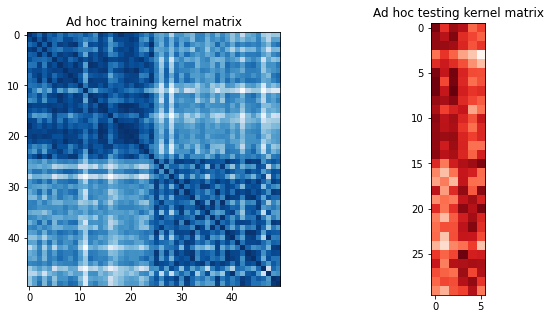

In [44]:
_, result = run_model('svm', None, training_input, test_input, datapoints)
display_kernel_matrices(result)

### QSVM

for feature map pauli
with entanglement linear
Testing success ratio: 0.8

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 94.73684210526316%


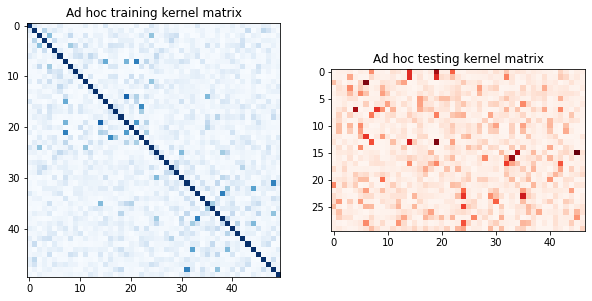

with entanglement circular
Testing success ratio: 0.8333333333333334

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['B', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'B', 'A', 'B', 'B']
  success rate: 63.1578947368421%


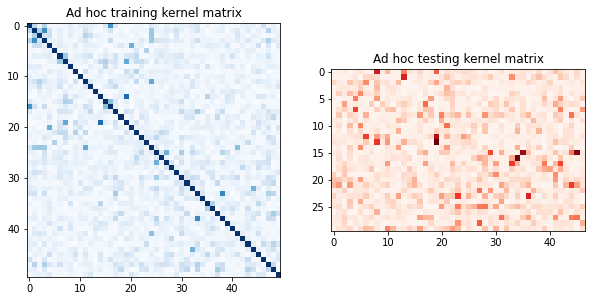

with entanglement full
Testing success ratio: 0.8333333333333334

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'B']
  success rate: 73.6842105263158%


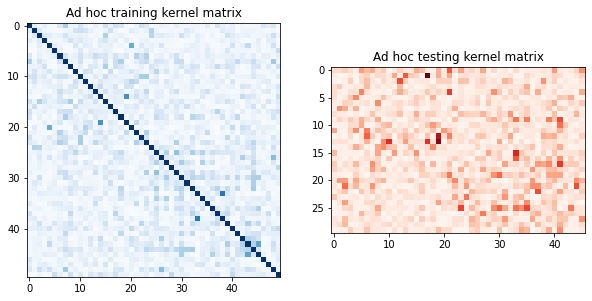

for feature map zz
Testing success ratio: 0.8333333333333334

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'B']
  success rate: 73.6842105263158%


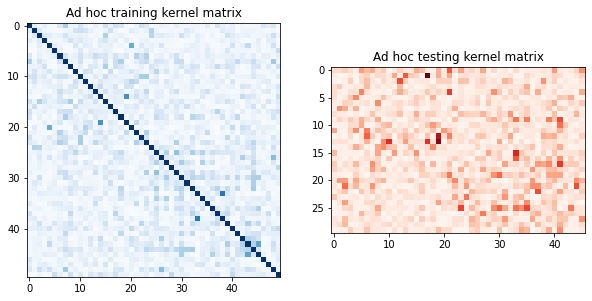

for feature map z
Testing success ratio: 1.0

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


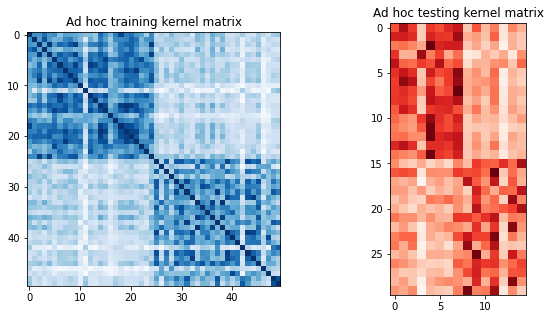

In [53]:
model = 'qsvm'
for feature in feature_maps:
	print(f'for feature map {feature}')
	if feature == 'pauli':
		for ent in entanglements:
			print(f'with entanglement {ent}')
			do_all(model, feature, adhoc_dimension, training_input, test_input, datapoints, ent=ent)
	else:
		do_all(model, feature, adhoc_dimension, training_input, test_input, datapoints, ent=None)

In [54]:
model = 'vqc'
for feature in feature_maps:
	print(f'for feature map {feature}')
	if feature == 'pauli':
		for ent in entanglements:
			print(f'with entanglement {ent}')
			do_all(model, feature, adhoc_dimension, training_input, test_input, datapoints, ent=ent)
	else:
		do_all(model, feature, adhoc_dimension, training_input, test_input, datapoints, ent=None)

for feature map pauli
with entanglement linear
Testing success ratio: 0.5666666666666667

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'B']
  success rate: 52.63157894736842%
with entanglement circular
Testing success ratio: 0.6666666666666666

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'A', 'B', 'B']
  success rate: 52.63157894736842%
with entanglement full
Testing success ratio: 0.5666666666666667

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'B', '

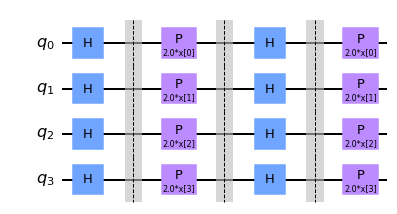

In [59]:
feature_dimension = 4
entanglement = 'circular'
# feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement=entanglement, insert_barriers=True)
# feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, insert_barriers=True)
feature_map = ZFeatureMap(feature_dimension=feature_dimension, reps=2, insert_barriers=True)
feature_map.decompose().draw(output='mpl', fold=-1)